<a href="https://colab.research.google.com/github/rish4/Colonoscopy-Feb22/blob/main/CNew_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.layers import Activation,Dropout,Flatten, Dense
from keras import backend as k
import numpy as np
from keras.preprocessing import image
import tensorflow as tf
import os
import cv2
import time
from numpy.random import seed
seed(1337)
import matplotlib.pyplot as plt
import tqdm
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Activation, Conv2D, Flatten, BatchNormalization, Dropout, MaxPool2D
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import np_utils
import pandas as pd
import tensorflow as tf
import time
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers

In [2]:
# re-size all the images to this
IMAGE_SIZE = [128, 128] 
img_width, img_height = 128, 128 # feel free to change depending on dataset

# training config:
epochs = 20
batch_size = 32

In [3]:
train_dir = "/content/drive/MyDrive/Colonoscopy Research'22/Dataset/NewDB/Training set"
#test_dir = "/content/drive/MyDrive/minor proj/Datasets/Cats&Dogs/test_set" 
val_dir = "/content/drive/MyDrive/Colonoscopy Research'22/Dataset/NewDB/Test set"

In [4]:
from glob import glob
# useful for getting number of classes
folders = glob(train_dir + '/*')

In [5]:
gen = ImageDataGenerator(rescale=1. / 255,
                              samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = True, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.2, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.2)

# get label mapping for confusion matrix plot later
#test_gen = gen.flow_from_directory(test_dir, target_size=IMAGE_SIZE)
#print(test_gen.class_indices)
#labels = [None] * len(test_gen.class_indices)
#for k, v in test_gen.class_indices.items():
#  labels[v] = k

In [6]:
# create generators
train_generator = gen.flow_from_directory(
  train_dir,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  val_dir,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)


Found 1656 images belonging to 2 classes.
Found 415 images belonging to 2 classes.


In [7]:
# add preprocessing layer to the front of Inception
inceptionv3 = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [8]:
# don't train existing weights
for layer in inceptionv3.layers:
  layer.trainable = False 

In [9]:
# our layers - you can add more if you want
x = Flatten()(inceptionv3.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [10]:
# create a model object
model = Model(inputs=inceptionv3.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 63, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [11]:
# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

NameError: ignored

In [11]:
# fit the model
r = model.fit_generator(
  generator=train_generator,
  steps_per_epoch= 32, 
  epochs=20,
  validation_data = valid_generator,
  validation_steps = 32, 
  max_queue_size=100, 
  use_multiprocessing=True
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/20
32/32 [==============================] - 680s 21s/step - loss: 0.9175 - accuracy: 0.7008 - val_loss: 0.6026 - val_accuracy: 0.7808
Epoch 2/20
32/32 [==============================] - 103s 3s/step - loss: 0.5312 - accuracy: 0.8154 - val_loss: 0.4224 - val_accuracy: 0.8356
Epoch 3/20
32/32 [==============================] - 107s 3s/step - loss: 0.4150 - accuracy: 0.8457 - val_loss: 0.3909 - val_accuracy: 0.8513
Epoch 4/20
32/32 [==============================] - 106s 3s/step - loss: 0.4171 - accuracy: 0.8584 - val_loss: 0.3532 - val_accuracy: 0.8542
Epoch 5/20
32/32 [==============================] - 104s 3s/step - loss: 0.3644 - accuracy: 0.8789 - val_loss: 0.3992 - val_accuracy: 0.8513
Epoch 6/20
32/32 [==============================] - 107s 3s/step - loss: 0.4233 - accuracy: 0.8467 - val_loss: 0.7066 - val_accuracy: 0.7857
Epoch 7/20
32/32 [==============================] - 103s 3s/step - loss: 0.5705 - accuracy: 0.8219 - val_loss: 0.6754 - val_accuracy: 0.8239
Epoch 8/20
3

In [12]:
r.history

{'accuracy': [0.7007874250411987,
  0.8154296875,
  0.845703125,
  0.8583984375,
  0.8789370059967041,
  0.8466796875,
  0.8218504190444946,
  0.8523622155189514,
  0.8484252095222473,
  0.8474409580230713,
  0.8494094610214233,
  0.8602362275123596,
  0.8523622155189514,
  0.8592519760131836,
  0.8789370059967041,
  0.8553149700164795,
  0.8837890625,
  0.8946850299835205,
  0.8631889820098877,
  0.880859375],
 'loss': [0.917538046836853,
  0.5311976075172424,
  0.4150012135505676,
  0.4170890152454376,
  0.3644489347934723,
  0.4233150780200958,
  0.570512592792511,
  0.42176222801208496,
  0.481454074382782,
  0.47613897919654846,
  0.5567957162857056,
  0.457558274269104,
  0.4419585168361664,
  0.37183088064193726,
  0.36949843168258667,
  0.4382539391517639,
  0.3496097922325134,
  0.3079782724380493,
  0.35791122913360596,
  0.31491369009017944],
 'val_accuracy': [0.7808219194412231,
  0.835616409778595,
  0.8512719869613647,
  0.854207456111908,
  0.8512719869613647,
  0.785714

In [13]:
history = r.history

In [ ]:
test_generator = gen.flow_from_directory(
  test_dir,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
# valid accuracy
score = model.evaluate(valid_generator, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

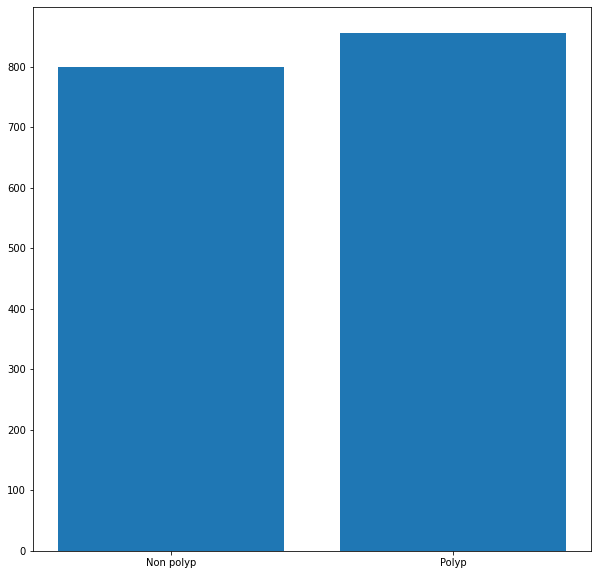

In [14]:
from sklearn.utils.class_weight import compute_class_weight
cls_train = train_generator.classes
from collections import OrderedDict
classes = list(train_generator.class_indices.keys())
num_values = []
unique, counts = np.unique(cls_train, return_counts=True)
valdict=OrderedDict(zip(unique, counts))
for i in range(2):
    num_values.append(valdict[i])
plt.figure(figsize=(10,10))
x = np.arange(len(num_values))
xlabel = classes
plt.bar(x, num_values)
plt.xticks(x, xlabel)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


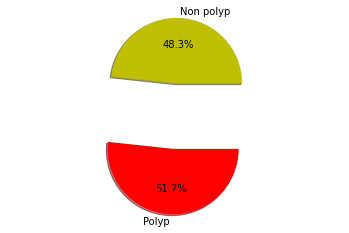

In [15]:
import matplotlib.pyplot as plt
goal_types = list(train_generator.class_indices.keys())
unique, counts = np.unique(cls_train, return_counts=True)
goals = [(counts)]
colors = ['y','r']
plt.pie(goals, labels = goal_types, colors=colors ,shadow = True, explode = (0.5,0.5), autopct = '%1.1f%%')
plt.axis('equal')
plt.show()

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
import seaborn as sns

def create_charts(model, history):
    ## DEFINE ##
    ## Define 1:  train & validation loss
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    ## Define 2: train & validation AUC
    train_auc_name = list(history.history.keys())[3]
    val_auc_name = list(history.history.keys())[1]
    train_auc = history.history[train_auc_name]
    val_auc = history.history[val_auc_name]
    
    ## Define 3: y_pred & y_true
    y_true = valid_generator.classes
    #print(y_true)
    Y_pred =model.predict_generator(valid_generator, steps = len(valid_generator))
    y_pred = (Y_pred >= 0.5).T[0]
    #print(y_pred)
    y_pred_prob = Y_pred.T[0]
    #print(y_pred_prob)
    
    ## PLOT ##
    fig = plt.figure(figsize=(13, 10))
    
    ## PLOT 1: TRAIN VS. VALIDATION LOSS 
    plt.subplot(2,2,1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    ## PLOT 2: TRAIN VS. VALIDATION AUC
    plt.subplot(2,2,2)
    plt.title("Training vs. Validation AUC Score")
    plt.plot(train_auc, label='training auc')
    plt.plot(val_auc, label='validation auc')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()
    
    ## PLOT 3: CONFUSION MATRIX
    plt.subplot(2,2,3)
      # Set up the labels for in the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    names = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ticklabels = ['cats', 'Dogs']

      # Create confusion matrix as heatmap
    sns.set(font_scale = 1.4)
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels )
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Confusion Matrix") #plt.title("Confusion Matrix\n", fontsize=10)
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14) 
    #plt.savefig('cm.png', transparent=True) 
    
    ## PLOT 4: ROC CURVE
    plt.subplot(2,2,4)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label = "Random (AUC = 50%)")
    plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc*100))
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc='best')
    #plt.savefig('roc.png', bbox_inches='tight', pad_inches=1)
    
    ## END PLOTS
    plt.tight_layout()
    ;
    
    ## Summary Statistics
    TN, FP, FN, TP = cm.ravel() # cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
    accuracy = (TP + TN) / np.sum(cm) # % positive out of all predicted positives
    precision = TP / (TP+FP) # % positive out of all predicted positives
    recall =  TP / (TP+FN) # % positive out of all supposed to be positives
    specificity = TN / (TN+FP) # % negative out of all supposed to be negatives
    f1 = 2*precision*recall / (precision + recall)
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    print(stats_summary)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


[Summary Statistics]
Accuracy = 48.67% | Precision = 50.77% | Recall = 30.70% | Specificity = 68.00% | F1 Score = 38.26%


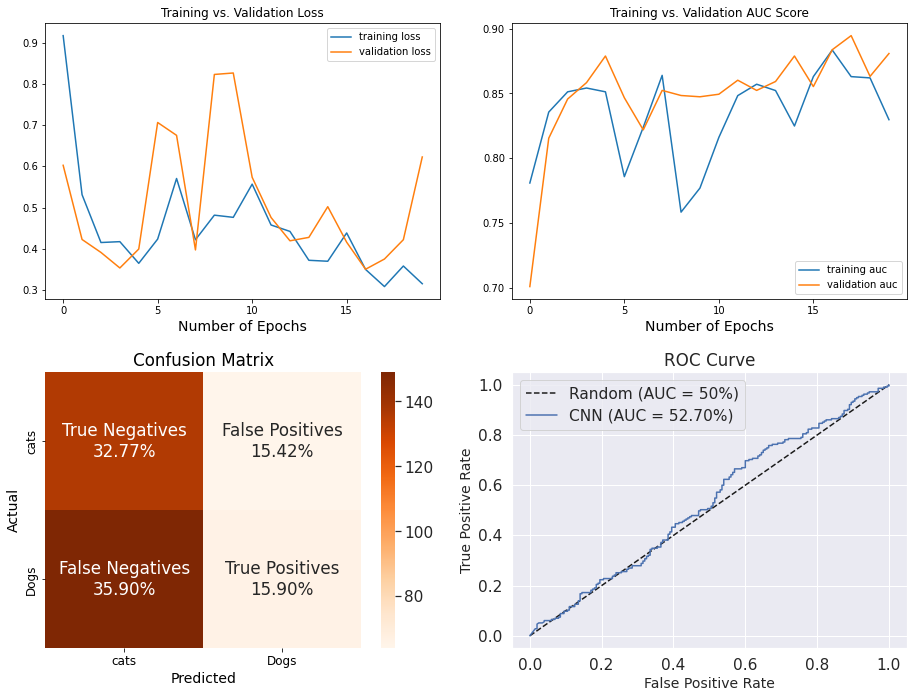

In [19]:
create_charts(model, r)